In [93]:
### OceanUptake_Box Diffusion Model
###    Oeschger, H., U. Siegenthaler, U. Schotterer and A. Gugelmann (1975)
###       A box diffusion model to study the carbon dioxide exchange in
###       nature.  Tellus,27, 168-192.
###
### This code explores the airborne fraction of fossil fuel CO2 for
### different time histories of emissions. The ocean is represented by a
### box-diffusion model, with a well-mixed layer over a diffussive
### thermocline/deep ocean.  The paramaters air-sea gas exchange, and of
### thermocline diffusivity are determined using C14. Like Oeschger et al.,
### a simple biotic uptake (CO2 fertilization of NPP minus delayed
### respiration perturbation) is included.
###
###
### Three cases of fossil fuel CO2 emiss
###    icase = 1:  Pulse release
###    icase = 2:  Step function release
###    icase = 3;  Exponentially increasing emission
### Two ways of calculating the airborne fraction
###    instantanous= annual increase/annual emission
###    cumulative = cumulative increase/cumulative emission
###
### na, nm (moles/m2) = perturbation DIC in the atm and mixed layer
###      due to FF addition
### cd(moles/m3) =  concentration of perturbation DIC due to FF addition
### kappa (m2/yr) = diffusivity in the thermocline
### Revelle (unitless) = Revelle factor
###
###                  _______________
###  atm              na
###                  _______________ fluxma
###  mixed layer      nm = cd(1)*h
###               (h)
###                  _______________ fluxmd
###  thermocline  (dz)  cd(2)
###                     -------   d/dt(cd)=kappa*d2/dz2(cd)
###               (dz)  cd(3)
###                      -------
###
###


In [94]:
import numpy as np
import matplotlib.pyplot as plt

In [95]:
### Box diffusion model

def BoxDiffusion(FFPg, mixing, Nyears, dt):
    
    
    tauam=mixing['tauam']
    kappa=mixing['kappa']
    
    ### Earth parameters
    Area=5.1e14               # area of globe M2
    massair=1e5/9.81          # kg air/m2
    moleair=massair/29e-3     # mole air/m2 surface
    Pg2moleC=1e15/12.       # 1 PgC in mole carbon
    unit=Pg2moleC/Area        # convert PgC to moleC/m2

    ### Ocean parameters
    Revelle=10.     
    hmix=75.          # meters - depth of mixed layer
    hdeep=4000.-hmix  # meters - total thickness of the deep ocean (including thermocline)

  
    
    ### Preindustrial Initialization
    co2ppm0=292    #preindustrial.  
    dic0=1850e-6   # dic0 in moleC/kgseawater
    Na=co2ppm0*1.e-6*moleair;     # moleC/m2 in atm
    Nm=dic0*1.024e3*hmix;  # moleC/m2 in mixed layer=(moleC/kgwater)*DensityWater(kg/m3)*depth of mixed layer
    tauma=tauam*(Nm/Na);     # Eqm:  areaglobe*Na/tauam = Nm/tauma*areaocean
    
    ### Terrestrial biosphere parameters/assumptions
    NPPPg=60.         #  PgC/yr
    NPP=NPPPg*unit    #  moleC/m2/year.  CAREFUL.  per m2 of surface area.  
    epsbio=0.         #  CO2 fertilization factor for terrestrial biosphere
    lagbio=60.        #  turnover time of carbon in biosphere in years
    
    dz=25
   
    Nlagbio=int(lagbio/dt)
    
    ## checking choice of model parameters
    dtmax=0.5*dz*dz/kappa;   # max value for computational stability
   
    Nz=int(np.ceil(hdeep/dz));   # number of vertical layers in model thermocline/deep
    Nsteps=len(FFPg)#int(np.ceil(Nyears/dt));    # number of time steps
    year=np.arange(0,Nyears,dt);
    
    na=np.zeros(Nsteps);
    nm=np.zeros(Nsteps);
    cd=np.zeros([Nz,Nsteps])
    FFcum=np.zeros(Nsteps)
    airfrac=np.zeros(Nsteps)
    mixfrac=np.zeros(Nsteps)
    deepfrac=np.zeros(Nsteps)
    deeptotal=np.zeros(Nsteps)
    fluxab=np.zeros(Nsteps)    # fluxab is positive atm to biosphere
    fluxam=np.zeros(Nsteps)    # fluxam is positive atm to mixed layer
    co2ppm=np.zeros(Nsteps)
    airborne=np.zeros(Nsteps)
    FFcum=np.zeros(Nsteps)
    biofrac=np.zeros(Nsteps)
    pdepth=np.zeros(Nsteps)
    totalfrac=np.zeros(Nsteps)
    
    FF=FFPg*unit;    # convert FF from Pg/yr to moleC/m2/yr
    
    
    ### Start integration with time
    for n in np.arange(1,Nsteps):
        ### Atmosphere
        na[n]=na[n-1]+FF[n]*dt-fluxam[n-1]*dt-fluxab[n-1]*dt
        ### Biosphere
        if n<=Nlagbio:
            fluxab[n] = epsbio*NPP*(na[n]/Na)  # too early for respiration
        else:
            fluxab[n] = epsbio*NPP*(na[n]/Na - na[n-Nlagbio]/Na)
        ### Mixed Layer
        nm[n]  = nm[n-1] + fluxam[n-1]*dt -(kappa*dt/dz)*(cd[0,n-1]-cd[1,n-1])
        fluxam[n] = na[n]/tauam - Revelle*nm[n]/tauma
        #fluxmd[n-1] = (kappa*dt/dz)*(cd[1,n-1]-cd[2,n-1])
        ### Deep Ocean
        cd[0,n] = nm[n]/hmix;    #cd(1,n) is concentration in the mixed layer
        for k in np.arange(1,Nz-1):
            cd[k,n]=(cd[k,n-1]+ 
                (kappa*dt/(dz*dz)) * ( cd[k-1,n-1]-2*cd[k,n-1]+cd[k+1,n-1] ))
        
        co2ppm[n]=(na[n]/moleair)*1e6
        airborne[n]=(na[n]-na[n-1]) / (FF[n-1]*dt)
        FFcum[n]=FFcum[n-1]+FF[n]*dt

        #total number of moles in the deep ocean:
        #Careful.  cd(1) is the mixed layer concentration.
        deeptotal[n]=np.sum(cd[1:Nz-1,n]*dz) # moles/m2
    
        airfrac[n] = (na[n]-na[0])/FFcum[n]
        mixfrac[n] = (nm[n]-nm[0])/FFcum[n]
        deepfrac[n]= (deeptotal[n]-deeptotal[0])/FFcum[n]
        biofrac[n] = 1-airfrac[n]-mixfrac[n]-deepfrac[n]
        
        #print(pdepth[n], cd[1,n])

        pdepth[n]=deeptotal[n]/cd[1,n]  # penetration depth of FF into deep ocean
   
        totalfrac[n]=airfrac[n]+mixfrac[n]+deepfrac[n]+biofrac[n]
    return(year,na, fluxab, nm, fluxam, cd, co2ppm, airborne, FFcum, deeptotal, airfrac, mixfrac, deepfrac, biofrac, pdepth, totalfrac)

In [96]:
fastcase={'tauam':5.7, 'kappa':4480}
slowcase={'tauam':9.1, 'kappa':3560}
probablecase={'tauam':7.3, 'kappa':3980} #3980
# tauma(yr).  time constant for mixed layer to atm flux.  Range is 6-9 years based on C14
# kappa(m2/yr).  turbulent diffusivity in deep ocean. typical: O(1 cm2/s).
#                Range:  3060 to 5580 m2/yr
# tauma and kappa are linked to match the distributin of C14 in the ocean


/var/folders/_7/v77p745x1g50nq04w088fz_h0000gn/T/ipykernel_32083/374074012.py:101: RuntimeWarning: invalid value encountered in double_scalars
  pdepth[n]=deeptotal[n]/cd[1,n]  # penetration depth of FF into deep ocean
/var/folders/_7/v77p745x1g50nq04w088fz_h0000gn/T/ipykernel_32083/374074012.py:87: RuntimeWarning: divide by zero encountered in double_scalars
  airborne[n]=(na[n]-na[n-1]) / (FF[n-1]*dt)


Text(0.5, 1.0, 'Atmospheric CO2')

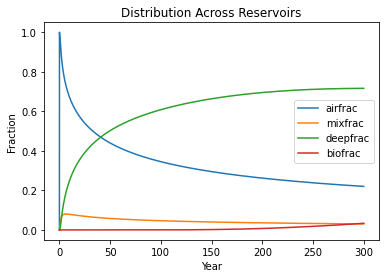

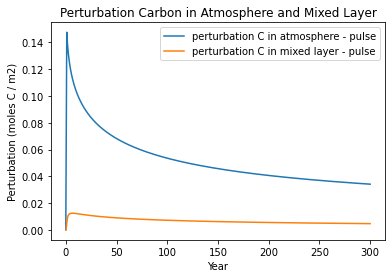

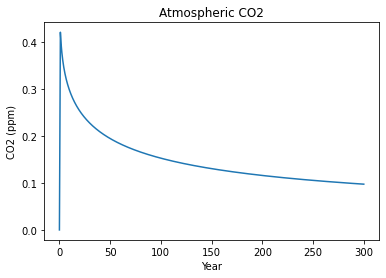

In [97]:
### Case: pulse release
Nyears=300 # stays the same
dt=0.05 # can change if needed
Nsteps=int(Nyears/dt) # stays the same

FFPg=np.zeros(Nsteps) # stays the same
FFPg[0:int(1/dt)]=1 # can change, for now: equals 1 Pg C/yr at t=0 and 0 at t>0

mixingcase=probablecase
[year, naA, fluxab, nmA, fluxam, cd, co2ppmA, airborne, FFcum, deeptotal, airfracA, mixfrac, deepfrac, biofrac, pdepth, totalfrac]=BoxDiffusion(FFPg, mixingcase, Nyears, dt)

#plot distribution across reservoirs
plt.figure()
plt.plot(year, airfracA, label='airfrac')
plt.plot(year, mixfrac, label='mixfrac')
plt.plot(year, deepfrac, label='deepfrac')
plt.plot(year, biofrac, label='biofrac')
plt.xlabel("Year")
plt.ylabel("Fraction")
plt.title("Distribution Across Reservoirs")
plt.legend()

plt.figure()
plt.plot(year, naA, label='perturbation C in atmosphere - pulse')
plt.plot(year, nmA, label='perturbation C in mixed layer - pulse')
plt.xlabel("Year")
plt.ylabel("Perturbation (moles C / m2)")
plt.title("Perturbation Carbon in Atmosphere and Mixed Layer")
plt.legend()

plt.figure()
plt.plot(year, co2ppmA)
plt.xlabel("Year")
plt.ylabel("CO2 (ppm)")
plt.title("Atmospheric CO2")

/var/folders/_7/v77p745x1g50nq04w088fz_h0000gn/T/ipykernel_32083/3831302830.py:101: RuntimeWarning: invalid value encountered in double_scalars
  pdepth[n]=deeptotal[n]/cd[1,n]  # penetration depth of FF into deep ocean


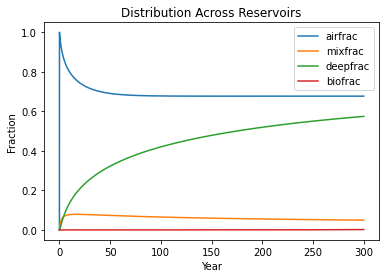

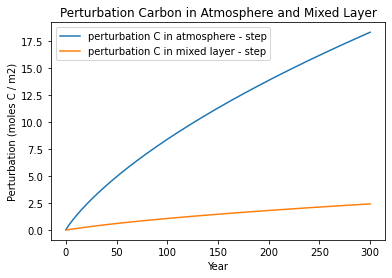

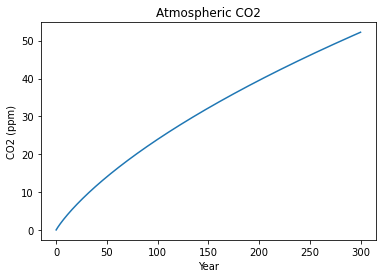

<Figure size 432x288 with 0 Axes>

In [84]:
### Case: step function
Nyears=300
dt=0.05
Nsteps=int(Nyears/dt) #play around with this for other cases

FFPg=np.zeros(Nsteps)
FFPg[0:Nsteps]=1 # step function (a)
#FFPg[0:int(200/dt)]=1 # step function (b)

mixingcase=probablecase
[year, naB, fluxab, nmB, fluxam, cd, co2ppmB, airborne, FFcum, deeptotal, airfracB, mixfrac, deepfrac, biofrac, pdepth, totalfrac]=BoxDiffusion(FFPg, mixingcase, Nyears, dt)
#plot distribution across reservoirs
plt.plot(year, airfrac, label='airfrac')
plt.plot(year, mixfrac, label='mixfrac')
plt.plot(year, deepfrac, label='deepfrac')
plt.plot(year, biofrac, label='biofrac')
plt.legend()
plt.xlabel("Year")
plt.ylabel("Fraction")
plt.title("Distribution Across Reservoirs")

plt.figure()
plt.plot(year, naB, label='perturbation C in atmosphere - step')
plt.plot(year, nmB, label='perturbation C in mixed layer - step')
plt.legend()
plt.xlabel("Year")
plt.ylabel("Perturbation (moles C / m2)")
plt.title("Perturbation Carbon in Atmosphere and Mixed Layer")

plt.figure()
plt.plot(year, co2ppmB, label='atmospheric CO2')
plt.xlabel("Year")
plt.ylabel("CO2 (ppm)")
plt.title("Atmospheric CO2")
plt.figure()

Area=5.1e14
Pg2moleC=1e15/12.       # 1 PgC in mole carbon
unit=Pg2moleC/Area        # convert PgC to moleC/m2


/var/folders/_7/v77p745x1g50nq04w088fz_h0000gn/T/ipykernel_32083/3831302830.py:101: RuntimeWarning: invalid value encountered in double_scalars
  pdepth[n]=deeptotal[n]/cd[1,n]  # penetration depth of FF into deep ocean
/var/folders/_7/v77p745x1g50nq04w088fz_h0000gn/T/ipykernel_32083/3831302830.py:87: RuntimeWarning: divide by zero encountered in double_scalars
  airborne[n]=(na[n]-na[n-1]) / (FF[n-1]*dt)


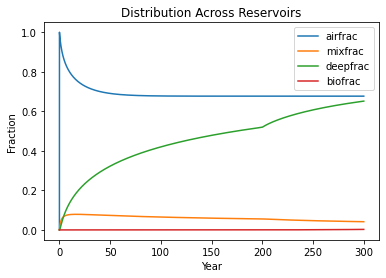

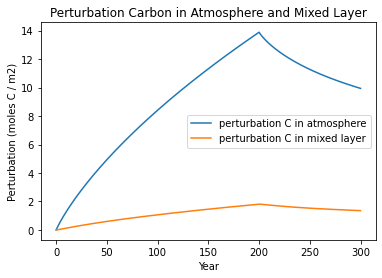

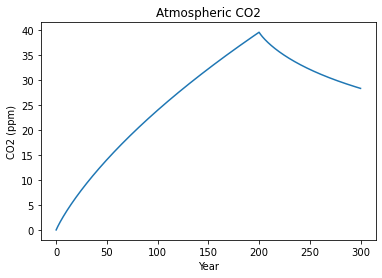

<Figure size 432x288 with 0 Axes>

In [85]:
### Case: step function
Nyears=300
dt=0.05
Nsteps=int(Nyears/dt) #play around with this for other cases

FFPg=np.zeros(Nsteps)
#FFPg[0:Nsteps]=1 # step function (a)
FFPg[0:int(200/dt)]=1 # step function (b)

mixingcase=probablecase
[year, na, fluxab, nm, fluxam, cd, co2ppmC, airborne, FFcum, deeptotal, airfracC, mixfrac, deepfrac, biofrac, pdepth, totalfrac]=BoxDiffusion(FFPg, mixingcase, Nyears, dt)
#plot distribution across reservoirs
plt.plot(year, airfrac, label='airfrac')
plt.plot(year, mixfrac, label='mixfrac')
plt.plot(year, deepfrac, label='deepfrac')
plt.plot(year, biofrac, label='biofrac')
plt.legend()
plt.xlabel("Year")
plt.ylabel("Fraction")
plt.title("Distribution Across Reservoirs")

plt.figure()
plt.plot(year, na, label='perturbation C in atmosphere')
plt.plot(year, nm, label='perturbation C in mixed layer')
plt.legend()
plt.xlabel("Year")
plt.ylabel("Perturbation (moles C / m2)")
plt.title("Perturbation Carbon in Atmosphere and Mixed Layer")

plt.figure()
plt.plot(year, co2ppmC, label='atmospheric CO2')
plt.xlabel("Year")
plt.ylabel("CO2 (ppm)")
plt.title("Atmospheric CO2")
plt.figure()

Area=5.1e14
Pg2moleC=1e15/12.       # 1 PgC in mole carbon
unit=Pg2moleC/Area        # convert PgC to moleC/m2


In [86]:
### Case: exponentially increasing emissions
Nyears=300
dt=0.05
Nsteps=int(Nyears/dt)
FF0=0.02
taue=34.5  #try varying this value of tau emissioins (taue) and mu for faster emissions ramp up
mu=1/taue
FFPg=np.zeros(Nsteps)
for n in range(Nsteps):
        FFPg[n]=FF0*np.exp(mu*n*dt);
tauam=5.7
kappa=4480

mixingcase=probablecase
[year, naC, fluxab, nmC, fluxam, cd, co2ppmD, airborne, FFcum, deeptotal, airfracD, mixfrac, deepfrac, biofrac, pdepth, totalfrac]=BoxDiffusion(FFPg, mixingcase, Nyears, dt)



/var/folders/_7/v77p745x1g50nq04w088fz_h0000gn/T/ipykernel_32083/3831302830.py:101: RuntimeWarning: invalid value encountered in double_scalars
  pdepth[n]=deeptotal[n]/cd[1,n]  # penetration depth of FF into deep ocean


<Figure size 432x288 with 0 Axes>

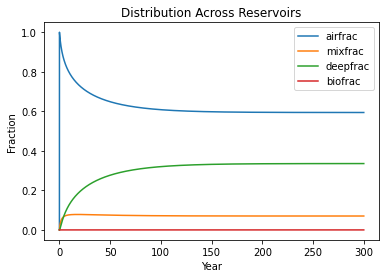

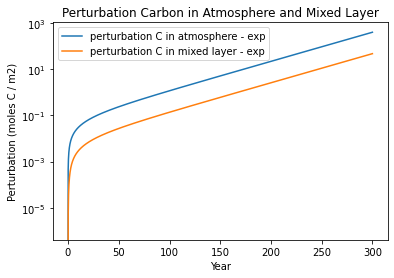

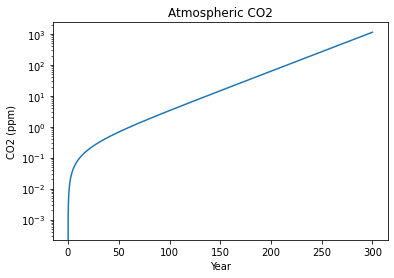

<Figure size 432x288 with 0 Axes>

In [79]:
#plot distribution across reservoirs
plt.plot(year, airfrac, label='airfrac')
plt.plot(year, mixfrac, label='mixfrac')
plt.plot(year, deepfrac, label='deepfrac')
plt.plot(year, biofrac, label='biofrac')
plt.legend()
plt.xlabel("Year")
plt.ylabel("Fraction")
plt.title("Distribution Across Reservoirs")

plt.figure()
plt.semilogy(year, naC, label='perturbation C in atmosphere - exp')
plt.semilogy(year, nmC, label='perturbation C in mixed layer - exp')
plt.legend()
plt.xlabel("Year")
plt.ylabel("Perturbation (moles C / m2)")
plt.title("Perturbation Carbon in Atmosphere and Mixed Layer")

plt.figure()
plt.semilogy(year, co2ppmD, label='atmospheric CO2')
plt.xlabel("Year")
plt.ylabel("CO2 (ppm)")
plt.title("Atmospheric CO2")
plt.figure()


/var/folders/_7/v77p745x1g50nq04w088fz_h0000gn/T/ipykernel_32083/3831302830.py:101: RuntimeWarning: invalid value encountered in double_scalars
  pdepth[n]=deeptotal[n]/cd[1,n]  # penetration depth of FF into deep ocean


<Figure size 432x288 with 0 Axes>

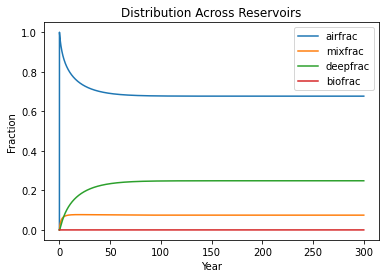

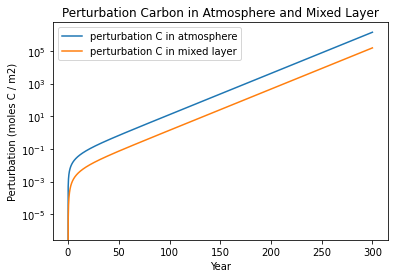

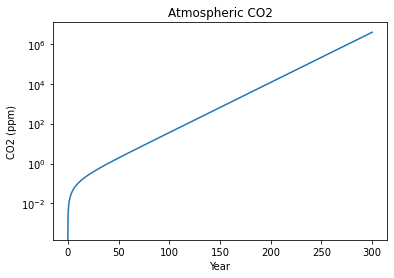

<Figure size 432x288 with 0 Axes>

In [87]:
### Case: exponentially increasing emissions
Nyears=300
dt=0.05
Nsteps=int(Nyears/dt)
FF0=0.02
taue=34.5  #try varying this value of tau emissioins (taue) and mu for faster emissions ramp up
mu=2/taue
FFPg=np.zeros(Nsteps)
for n in range(Nsteps):
        FFPg[n]=FF0*np.exp(mu*n*dt);
tauam=5.7
kappa=4480

mixingcase=probablecase
[year, na, fluxab, nm, fluxam, cd, co2ppmE, airborne, FFcum, deeptotal, airfracE, mixfrac, deepfrac, biofrac, pdepth, totalfrac]=BoxDiffusion(FFPg, mixingcase, Nyears, dt)

#plot distribution across reservoirs
plt.plot(year, airfrac, label='airfrac')
plt.plot(year, mixfrac, label='mixfrac')
plt.plot(year, deepfrac, label='deepfrac')
plt.plot(year, biofrac, label='biofrac')
plt.legend()
plt.xlabel("Year")
plt.ylabel("Fraction")
plt.title("Distribution Across Reservoirs")

plt.figure()
plt.semilogy(year, na, label='perturbation C in atmosphere')
plt.semilogy(year, nm, label='perturbation C in mixed layer')
plt.legend()
plt.xlabel("Year")
plt.ylabel("Perturbation (moles C / m2)")
plt.title("Perturbation Carbon in Atmosphere and Mixed Layer")

plt.figure()
plt.semilogy(year, co2ppmE, label='atmospheric CO2')
plt.xlabel("Year")
plt.ylabel("CO2 (ppm)")
plt.title("Atmospheric CO2")
plt.figure()


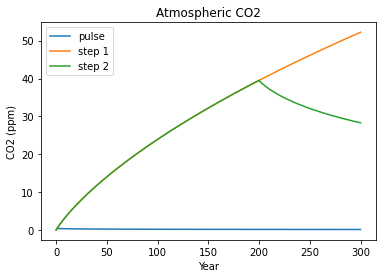

In [63]:
plt.figure()
plt.plot(year, co2ppmA, label='pulse')
plt.plot(year, co2ppmB, label='step 1')
plt.plot(year, co2ppmC, label='step 2')
#plt.plot(year, co2ppmD, label='exp 1')
#plt.plot(year, co2ppmE, label='exp 2')
plt.xlabel("Year")
plt.ylabel("CO2 (ppm)")
plt.title("Atmospheric CO2")
plt.legend()

Text(0.5, 1.0, 'Perturbation Carbon in Atmosphere and Mixed Layer')

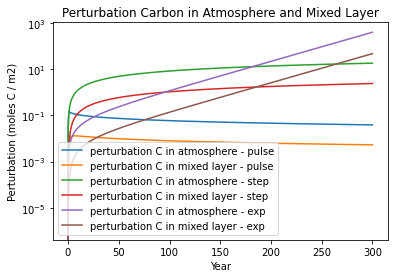

In [72]:
plt.figure()
plt.semilogy(year, naA, label='perturbation C in atmosphere - pulse')
plt.semilogy(year, nmA, label='perturbation C in mixed layer - pulse')
plt.semilogy(year, naB, label='perturbation C in atmosphere - step')
plt.semilogy(year, nmB, label='perturbation C in mixed layer - step')
plt.semilogy(year, naC, label='perturbation C in atmosphere - exp')
plt.semilogy(year, nmC, label='perturbation C in mixed layer - exp')
plt.legend()
plt.xlabel("Year")
plt.ylabel("Perturbation (moles C / m2)")
plt.title("Perturbation Carbon in Atmosphere and Mixed Layer")

Text(0.5, 1.0, 'Airborne Fraction Across All Scenarios')

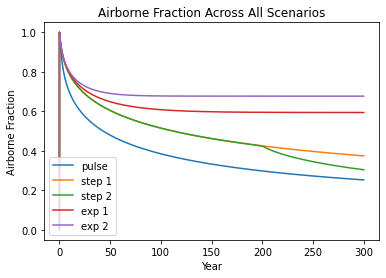

In [88]:
plt.figure()
plt.plot(year, airfracA, label='pulse')
plt.plot(year, airfracB, label='step 1')
plt.plot(year, airfracC, label='step 2')
plt.plot(year, airfracD, label='exp 1')
plt.plot(year, airfracE, label='exp 2')
plt.legend()
plt.xlabel("Year")
plt.ylabel("Airborne Fraction")
plt.title("Airborne Fraction Across All Scenarios")